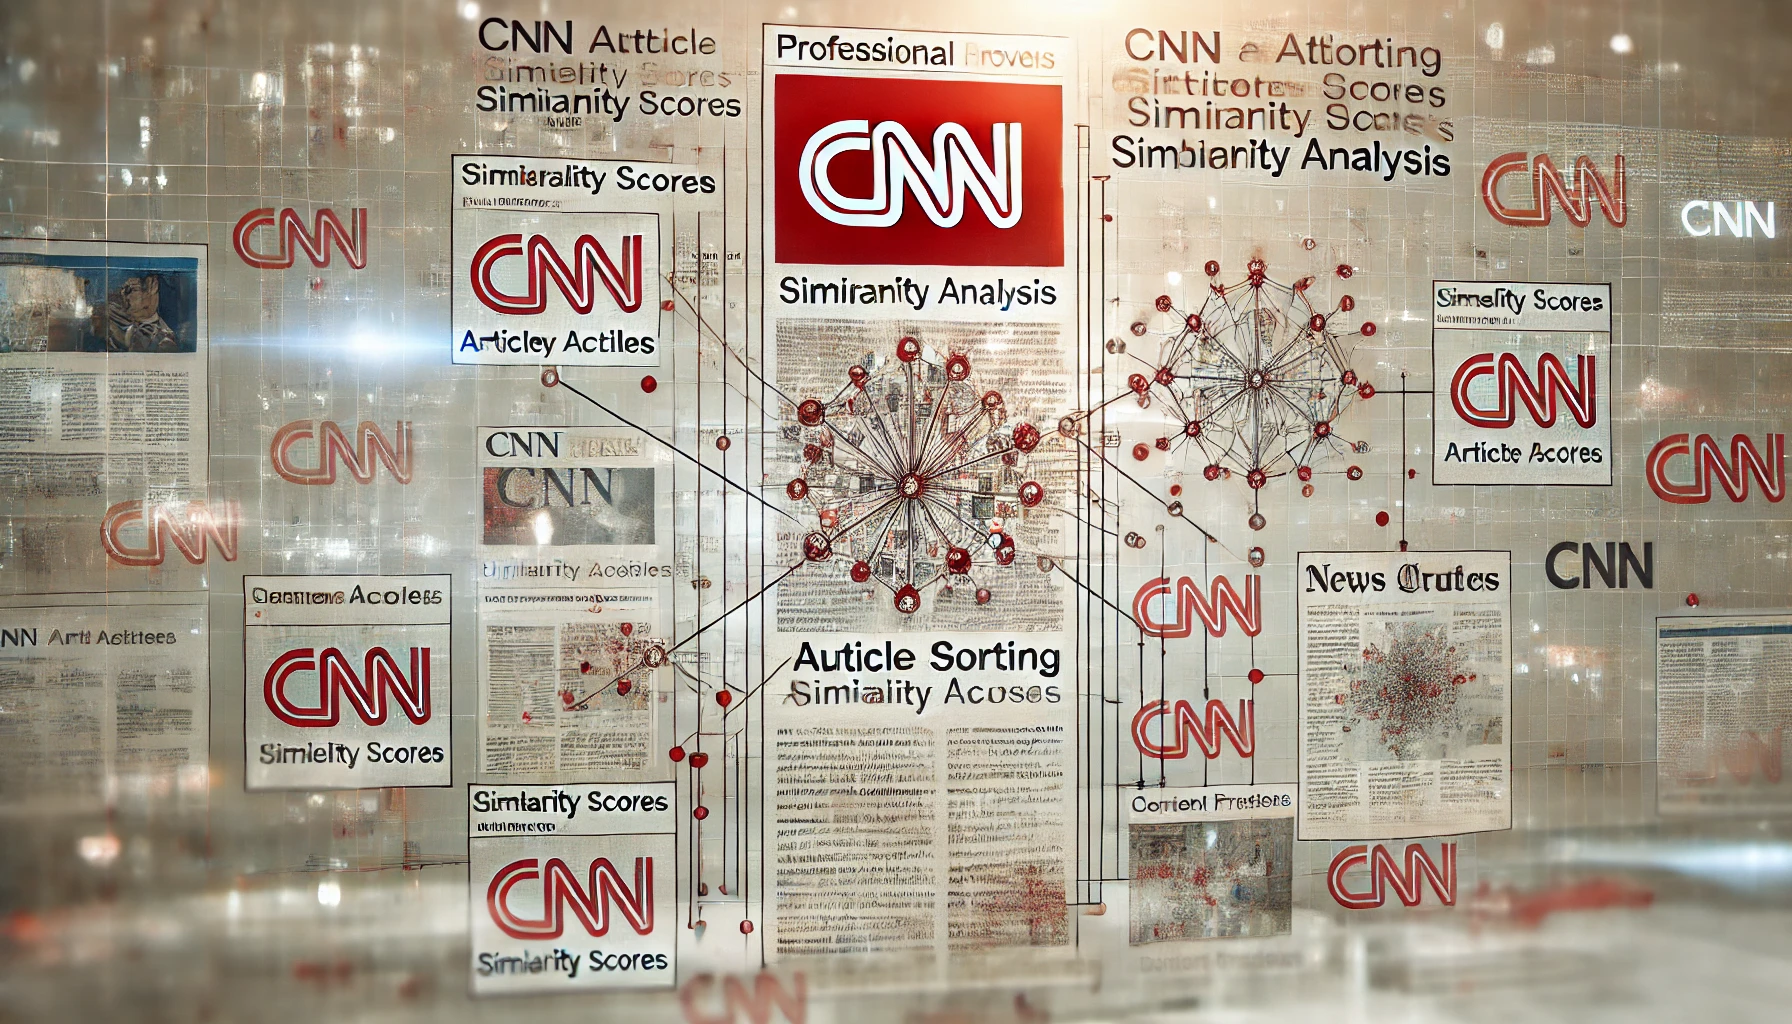

# **Problem Statement**

With the overwhelming volume of news articles published daily, it’s challenging for news agencies and content aggregators to organize, relate, and recommend relevant content effectively. This project aims to develop a model that automatically identifies and sorts related articles from CNN based on similarity, enabling efficient clustering of related news topics. Such a solution will streamline content discovery and help users locate pertinent information faster.


# **Objectives**

1. **Identify Related Articles**: Develop a similarity-matching algorithm to compare and rank articles based on textual content.
2. **Automate Content Sorting**: Implement an automated process that clusters related articles, reducing manual effort in content categorization.
3. **Optimize Content Recommendations**: Enable a recommendation system that suggests related articles to readers, improving engagement by linking stories of similar topics.
4. **Track Content Progression Over Time**: Allow users to view the evolution of news topics by linking related articles published across different dates.

# **Business Impact**

1. **Enhanced User Experience**: By providing readers with related article suggestions, users can easily navigate and explore news topics in depth, increasing site engagement and user satisfaction.
2. **Improved Content Management**: Automated clustering of articles reduces the need for manual categorization, saving resources and enabling more efficient content management.
3. **Increased Ad Revenue**: More time spent by users on the site due to effective content recommendations can lead to higher ad impressions, positively impacting ad revenue.
4. **Data-Driven Content Strategy**: Insights from popular clusters can inform editorial decisions, highlighting trending topics and helping journalists focus on impactful stories.

# Load the libraries

In [ ]:
!pip install sentence-transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 3.5 MB/s eta 0:00:00


In [ ]:
import gdown
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Download the dataset

In [ ]:
# Download the file from Google Drive using gdown
url = 'https://drive.google.com/uc?id=1WoFQXSwT7GOOHEm7QPhRqBT-6sx35v-3'
output_file = 'CNN_Articles_clean.csv'
gdown.download(url, output_file, quiet=False)

df = pd.read_csv(output_file, encoding='utf-8')

Downloading...
From (original): https://drive.google.com/uc?id=1WoFQXSwT7GOOHEm7QPhRqBT-6sx35v-3
From (redirected): https://drive.google.com/uc?id=1WoFQXSwT7GOOHEm7QPhRqBT-6sx35v-3&confirm=t&uuid=132d51d9-1aba-45e4-81e9-6616204b15db
To: /content/CNN_Articles_clean.csv
100%|██████████| 241M/241M [00:05<00:00, 46.7MB/s]


In [ ]:
df.nunique()

,0
Index,37949
Author,11744
Date published,37948
Category,9
Section,55
Url,37949
Headline,37857
Description,37829
Keywords,37863
Second headline,37881


In [ ]:
df = df.dropna(subset=['Article text'])
df = df.drop_duplicates(subset=['Article text'])
df['Article text'] = df['Article text'].str.strip()

df = df[df['Article text'].str.len() > 0]

print(f"Number of articles after filtering: {len(df)}")

Number of articles after filtering: 37915


# Loading the SBERT model

In [ ]:
articles = df['Article text'].tolist()

# Use SBERT to embed articles
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Generate embeddings for each article and the similarity matrix

In [ ]:
embeddings = model.encode(articles, show_progress_bar=True, convert_to_tensor=False)
cosine_sim_matrix = cosine_similarity(embeddings)

similarity_df = pd.DataFrame(cosine_sim_matrix, columns=[f'Article {i}' for i in range(len(articles))], index=[f'Article {i}' for i in range(len(articles))])

Batches:   0%|          | 0/1185 [00:00<?, ?it/s]

# Print all the news articles that are related to each other

In [ ]:
def find_related_articles_exclude_exact(sim_matrix, threshold, top_n):
    related_articles = {}

    for idx in range(sim_matrix.shape[0]):
        sim_scores = sim_matrix[idx]

        # Exclude self-comparison (score 1.0) and scores below the threshold
        related_indices = [
            (i, sim_scores[i])
            for i in sim_scores.argsort()[::-1]
            if i != idx and sim_scores[i] < 1.0 and sim_scores[i] > threshold
        ][:top_n]  # Get top_n articles

        related_articles[f'Article {idx}'] = [(f'Article {i}', score) for i, score in related_indices]

    return related_articles

# Setting cosine similairy value threshold as 0.9 and upto 5 articles

In [ ]:
# Define cosine similarity matrix as 'cosine_sim_matrix' from earlier steps
related_articles = find_related_articles_exclude_exact(cosine_sim_matrix, threshold=0.9, top_n=5)

# Print related articles, avoiding redundancy and exact similarity
reported_pairs = set()  # To track already reported pairs

for article, related in related_articles.items():
    if related:
        related_str = []
        for rel_article, score in related:
            # Check if the pair has been reported before
            pair = tuple(sorted([article, rel_article]))

            # Exclude printing pairs that have already been reported
            if pair not in reported_pairs:
                reported_pairs.add(pair)
                related_str.append(f"{rel_article} (Similarity Score: {score:.2f})")

        # Print only if there are related articles (excluding self-comparison)
        if related_str:
            print(f"{article} is most related to: {', '.join(related_str)}")

Article 328 is most related to: Article 37647 (Similarity Score: 0.94), Article 37641 (Similarity Score: 0.93), Article 37663 (Similarity Score: 0.93), Article 37677 (Similarity Score: 0.93), Article 37661 (Similarity Score: 0.92)
Article 381 is most related to: Article 32853 (Similarity Score: 0.95)
Article 510 is most related to: Article 511 (Similarity Score: 0.92)
Article 516 is most related to: Article 524 (Similarity Score: 0.92), Article 530 (Similarity Score: 0.92), Article 531 (Similarity Score: 0.90)
Article 522 is most related to: Article 4855 (Similarity Score: 0.93)
Article 523 is most related to: Article 524 (Similarity Score: 0.90)
Article 524 is most related to: Article 4848 (Similarity Score: 0.96), Article 531 (Similarity Score: 0.94), Article 530 (Similarity Score: 0.92), Article 529 (Similarity Score: 0.91)
Article 529 is most related to: Article 531 (Similarity Score: 0.90)
Article 530 is most related to: Article 531 (Similarity Score: 0.92), Article 4848 (Similari

# Print all the news article's Headline and Date Published that are related to each other

In [ ]:
def find_related_articles_exclude_exact(sim_matrix, threshold, top_n):
    related_articles = {}

    for idx in range(sim_matrix.shape[0]):
        sim_scores = sim_matrix[idx]

        # Exclude self-comparison (score 1.0) and scores below the threshold
        related_indices = [
            (i, sim_scores[i])
            for i in sim_scores.argsort()[::-1]
            if i != idx and sim_scores[i] < 1.0 and sim_scores[i] > threshold
        ][:top_n]  # Get top_n articles

        related_articles[idx] = [(i, score) for i, score in related_indices]

    return related_articles

# Setting cosine similairy value threshold as 0.9 and upto 5 articles

In [ ]:
# Get related articles
related_articles = find_related_articles_exclude_exact(cosine_sim_matrix, threshold=0.9, top_n=5)

# Print related articles with metadata
reported_pairs = set()  # To track already reported pairs

for idx, related in related_articles.items():
    if related:
        article_info = df.iloc[idx]  # Get metadata of the article
        article_heading = article_info['Headline'] if 'Headline' in df.columns else f'Article {idx}'
        article_date = article_info['Date published'] if 'Date published' in df.columns else 'Unknown Date'

        related_str = []
        for rel_idx, score in related:
            # Check if the pair has been reported before
            pair = tuple(sorted([idx, rel_idx]))

            if pair not in reported_pairs:
                reported_pairs.add(pair)

                # Get related article metadata
                rel_article_info = df.iloc[rel_idx]
                rel_heading = rel_article_info['Headline'] if 'Headline' in df.columns else f'Article {rel_idx}'
                rel_date = rel_article_info['Date published'] if 'Date published' in df.columns else 'Unknown Date'

                related_str.append(f"{rel_heading} (Date published: {rel_date}, Similarity Score: {score:.2f})")

        # Print article metadata with related articles
        if related_str:
            print(f"'{article_heading}' (Date published: {article_date}) is most related to: {', '.join(related_str)}")

'Here's who won gold medals at the Beijing Olympics on Sunday - CNN' (Date published: 2022-02-20 09:47:01) is most related to: Here's who won gold medals at the Beijing Olympics on Tuesday - CNN (Date published: 2022-02-15 16:02:18, Similarity Score: 0.94), Here's who won gold medals at the Beijing Olympics on Wednesday - CNN (Date published: 2022-02-16 16:18:00, Similarity Score: 0.93), Here's who won gold medals at the Beijing Olympics on Saturday - CNN (Date published: 2022-02-12 15:09:41, Similarity Score: 0.93), Here's who won gold medals at the Beijing Olympics on Thursday - CNN (Date published: 2022-02-10 17:04:34, Similarity Score: 0.93), Here's who won gold medals at the Beijing Olympics on Friday - CNN (Date published: 2022-02-11 17:27:10, Similarity Score: 0.92)
'Alex Zanardi transferred to specialist neuro-rehabilitation center after crash - CNN' (Date published: 2020-07-21 14:52:17) is most related to: Alex Zanardi transferred to intensive care unit   - CNN (Date published


# **Conclusion**

The CNN Articles Sorting project successfully demonstrates an automated system for finding and grouping related news articles based on their textual content. By calculating similarity scores, it effectively organizes news content, making it easier to track developments within topics and enhancing the user experience by linking related stories. The project not only facilitates better content management but also supports editorial and business objectives, enabling data-driven decisions.

# **Scope of Improvement**

1. **Advanced NLP Techniques**: The similarity calculation can be refined using advanced models like BERT or GPT for improved understanding of contextual relationships between articles.
2. **User-Specific Recommendations**: Incorporate a recommendation engine that personalizes article suggestions based on users’ reading history and preferences.
3. **Topic Segmentation**: Apply topic modeling to categorize articles into predefined subjects (e.g., sports, politics, technology) for more granular clustering.
4. **Real-Time Updates**: Integrate a real-time updating mechanism to continuously analyze new articles, ensuring the system remains current with emerging news trends.
5. **Sentiment Analysis**: Add sentiment analysis to understand the emotional tone of articles, allowing clustering not only by topic but also by sentiment, which could be useful for varied user engagement strategies.